In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lora_modem import LoraModulator, LoraDemodulator, LoraReservedArtifacts, LoraOriginalSynchronizer, LoraCorrelationSynchronizer, SimpleLoraMoDem, Codec


In [2]:
def get_number_from_user():
    # Automatically computes the group number for the logged in user at that moment
    import os
    import re
    jupyterhub_username = os.environ['JUPYTERHUB_USER']
    print("Logged In User: ",jupyterhub_username)
    # The regex will match one or more digits, so it works for numbers with more than one digit
    match = re.search(r'sdrlab_user(\d+)', jupyterhub_username)
    group_number = match.group(1)
    return int(group_number)
    
def get_sdr_info(group_number= None):
    # Get the IP and Carrier Frequency of the SDR for the group number
    
    if group_number is None:
        # If group number is not provided, get it from the user automatically
        group_number = get_number_from_user()
    
    if group_number <= 0 or group_number > 13 or not isinstance(group_number, int):
        raise ValueError("Invalid group number")
    
    # IP and Carrier Frequency of the SDRs for each group
    IPs = [-1, 'ip:192.168.1.31', 'ip:192.168.1.31', 'ip:192.168.1.32', 'ip:192.168.1.32', 'ip:192.168.1.33', 'ip:192.168.1.33', 'ip:192.168.1.34', 'ip:192.168.1.34', 'ip:192.168.1.35', 'ip:192.168.1.35', 'ip:192.168.1.36', 'ip:192.168.1.36', 'ip:192.168.1.37', 'ip:192.168.1.37']
    Carrier_freq = [-1, 910e6, 914e6, 918e6, 922e6, 926e6, 930e6, 934e6, 938e6, 942e6, 946e6, 950e6, 954e6, 958e6, 962e6]
    
    # Print and return the IP and Carrier Frequency of the SDR for the group number
    print(f"SDR for group {group_number}: \nIP: \"{IPs[group_number]}\" \nCarrier Frequency: {Carrier_freq[group_number]}")
    return IPs[group_number], Carrier_freq[group_number]

ip, CarrierFreq = get_sdr_info()

Logged In User:  sdrlab_user9
SDR for group 9: 
IP: "ip:192.168.1.35" 
Carrier Frequency: 942000000.0


In [3]:
import adi

#------------------------------- SDR Parameter Configuration -------------------------------

Uri              = ip            # RELLENADO CON LA IP DEL SDR ASIGNADO
SamplingRate     = 2e6           # Sample rate RX and TX paths[Samples/Sec]
Loopback         = 0             # 0=Disabled, 1=Digital, 2=RF

TxLOFreq         = CarrierFreq         # Carrier frequency of TX path [Hz] RELLENAR CON LA FREC. DE PORTADORA ASIGNADA
TxAtten          = -10           # Attenuation applied to TX path, valid range is -90 to 0 dB [dB]
TxRfBw           = 4e6           # Bandwidth of front-end analog filter of TX path [Hz]

RxLOFreq         = TxLOFreq      # Carrier frequency of RX path [Hz]
GainControlModes = "fast_attack" # Receive path AGC Options: slow_attack, fast_attack, manual
RxHardwareGain   = 0             # Gain applied to RX path. Only applicable when gain_control_mode is set to 'manual'    
RxRfBw           = TxRfBw        # Bandwidth of front-end analog filter of RX path [Hz] 
RxBufferSize     = 2**20-1

#------------------------------- SDR Setup ------------------------------- 

sdr             = adi.Pluto(Uri)
sdr.sample_rate = SamplingRate
sdr.loopback    = Loopback
#Tx:
sdr.tx_lo                 = int(TxLOFreq)
sdr.tx_hardwaregain_chan0 = TxAtten 
sdr.tx_rf_bandwidth       = int(TxRfBw)
sdr.tx_cyclic_buffer      = True
# Rx:
sdr.rx_lo                   = int(RxLOFreq)
sdr.gain_control_mode_chan0 = GainControlModes
sdr.rx_rf_bandwidth         = int(RxRfBw)
sdr.rx_cyclic_buffer        = False
sdr.rx_buffer_size          = RxBufferSize

In [ ]:
# ------ Modulator, Demodulator, Synchronizer & Work Parameters Setup ------

# LoRa Parameters
spreading_factor = 8
bandwidth = 125e3
samples_per_chip = 5
preamble_number = 8

# Modulator, Demodulator, Synchronizer setup & Construction
modulator    = LoraModulator(spreading_factor, bandwidth, samples_per_chip)
demodulator  = LoraDemodulator(spreading_factor, bandwidth, samples_per_chip)
synchronizer = LoraOriginalSynchronizer(spreading_factor, samples_per_chip, demodulator, preamble_number)
lora_codec   = Codec(spreading_factor, bandwidth, samples_per_chip)

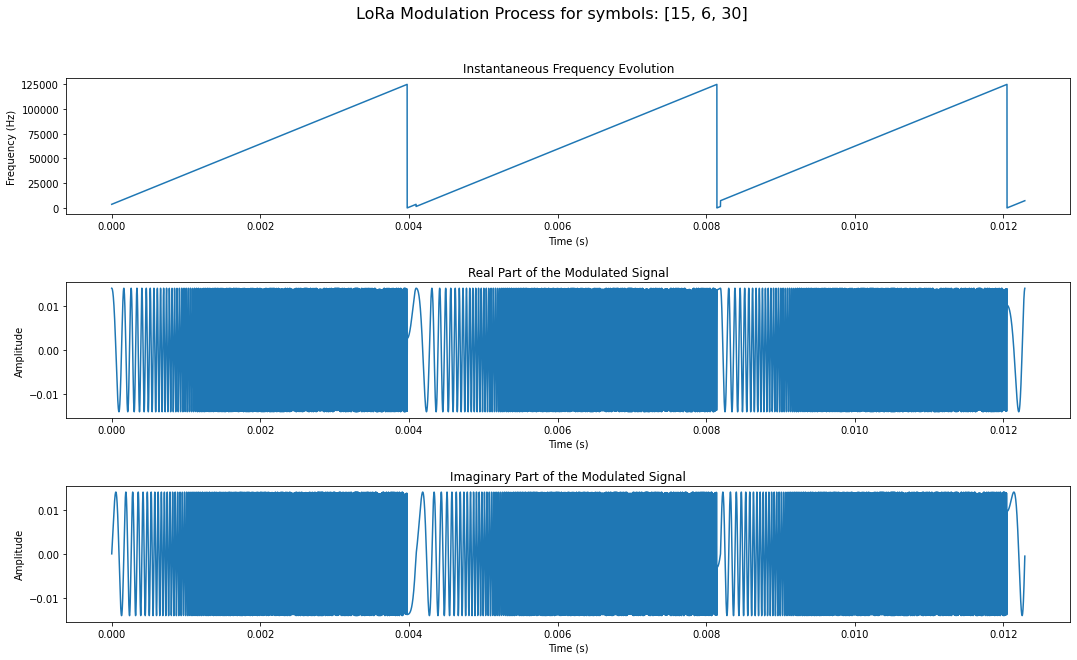

Synchronization started...
Phase 1: Searching for upchirps...
Phase 2: Ensuring that the candidate upchirp is a preamble member...
Preamble allegedly found at index:  1548
Phase 3: Refining synchronization index... (SPC > 1 requires it)
Offset quality measurements:  [0.99526422 1.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
Offset that ensures Highest Quality Synchronization:  1
Synchronization successful!
-----------------------------------------------------------
Preamble found at index:  1549
Refined by an offset of:  1
Package length:  3
Payload starts at index:  64269
Reconstructed preamble: [10 upchirps, 2 downchirps]


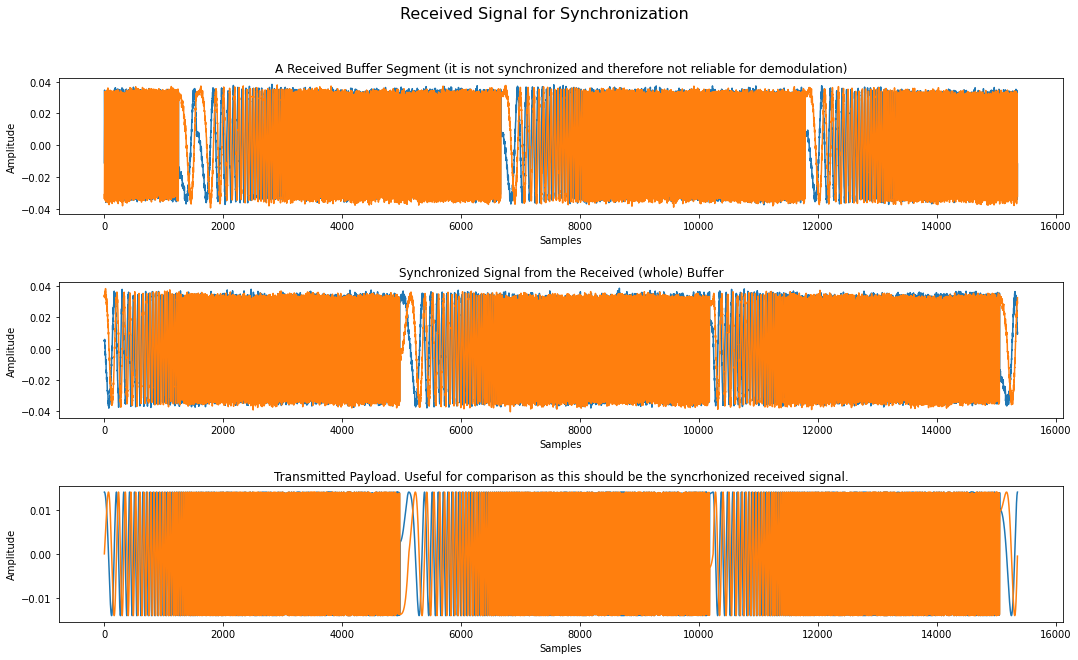

/home/jupyter-sdrlab_user9/.local/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/jupyter-sdrlab_user9/.local/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


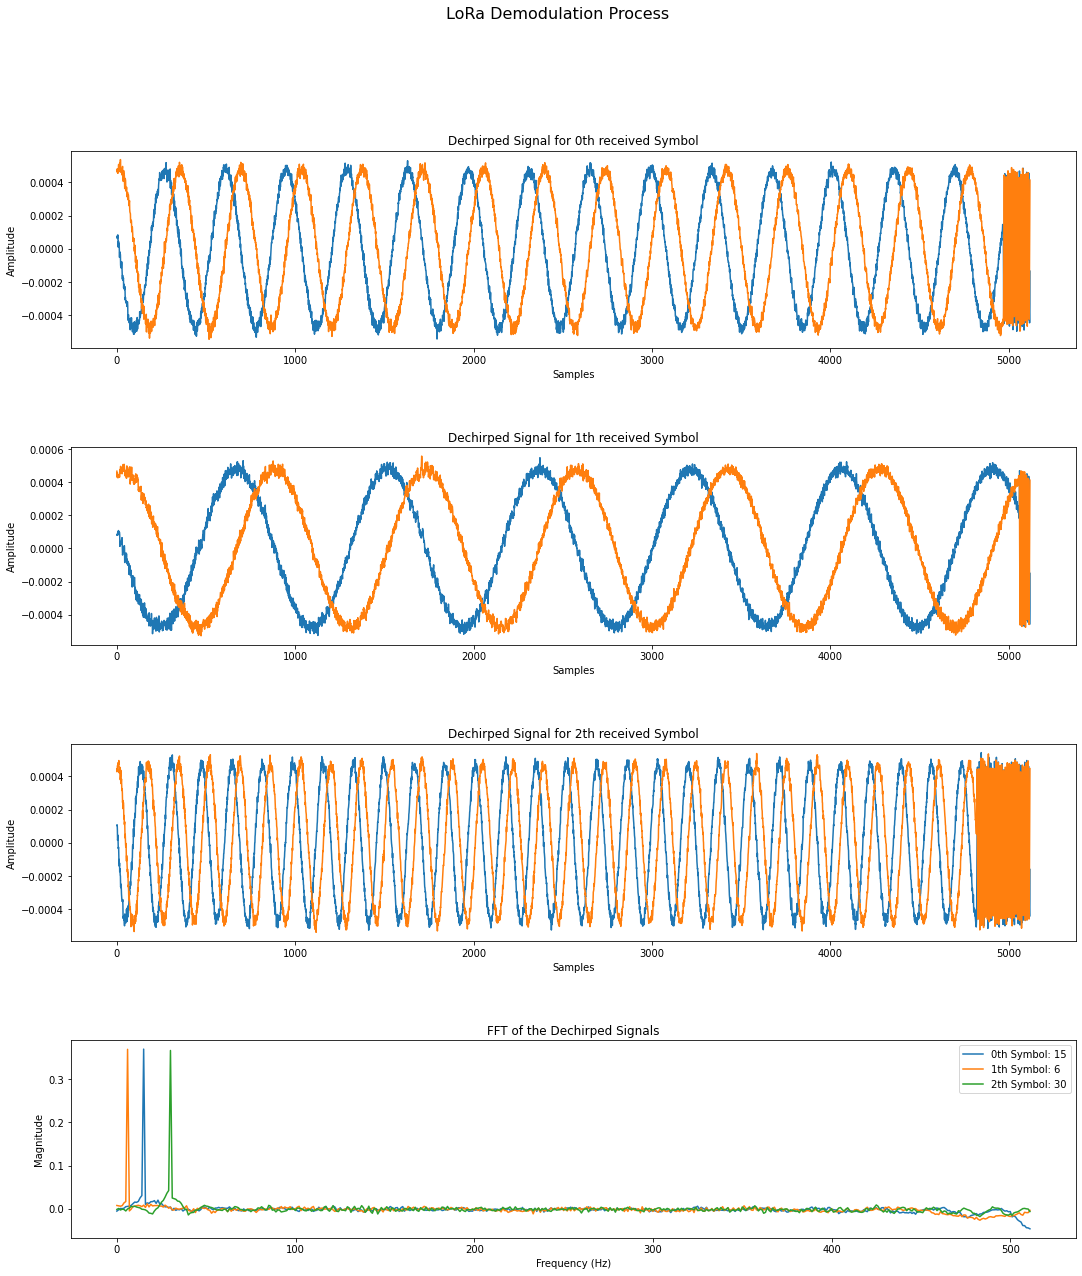

Received symbols:  [15, 6, 30]


In [ ]:
# ----- Playground -----

# Define the symbols of the payload (What you want to transmit)
message = b'Hello World!'
print('Message to send: ', message.decode('utf-8'))
payload = lora_codec.encode(message) # Encode the payload

# Modulate and transmit the package for the given payload, with plotting enabled
pkg_signal, payload_signal = modulator.modulate_n_plot_explicit_package(preamble_number, payload, plot_with_preamble=False, return_payload_signal=True)

# Transmit the package
sdr.tx(pkg_signal * 2**14)

# Receive a buffer that contains the transmitted package (if there is any)
rx_buffer = sdr.rx() / 2**14

# Synchronize the received buffer and extract the payload, with plotting enabled
sync_rx_payload = synchronizer.synchronize_rx_buffer(rx_buffer)
synchronizer.plot_synchronization(rx_buffer, sync_rx_payload, payload_signal)

# Demodulate the received payload (if there is any), with plotting enabled
if sync_rx_payload is not None:
    received_symbols = demodulator.demodulate_n_plot_symbols(sync_rx_payload)
    print('Received symbols: ', received_symbols)

    # Decode the received payload
    received_message = lora_codec.decode(received_symbols).decode('utf-8')
    print('Received message: ', received_message)

In [6]:
# Since it is not possible to turn off Tx, it is configured to transmit at low power and on a different frequency than Rx.
sdr.tx_destroy_buffer()
sdr.tx_hardwaregain_chan0 = -89 
sdr.tx_lo                 = int(2400e6)
sdr.rx_lo                 = int(950e6)
sdr.tx(np.zeros(2048))
# Destroy radio object
del(sdr)